In [ ]:
!pip3 install numpy matplotlib scipy pandas scikit-learn torch

In [3]:
# import required libraries
from cloud_distance_matching import *
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
from scipy import optimize as opt
from sklearn import linear_model
from scipy.spatial import procrustes
from scipy.stats import wasserstein_distance

#  Lorenz Attractor
Next we will attempt to implement our approach above for the Lorenz Attractor descroibed as,

\begin{align*}
\frac{dx}{dt} &= \sigma(y-x) \\
\frac{dy}{dt} &= x(\rho - z) - y \\
\frac{dz}{dt} &= xy -\beta z
\end{align*}

here we will consider the case that $\sigma = 10, \beta=\frac{8}{3}, \rho=28$, with intial condition $x(0)=0, y(0)=1, z(0)=1.05$.

In [4]:
# set the parameters
sigma = 10
beta = 8/3
rho = 28

# define the lorenz attractor
def lorenz_attractor(xyz, t):
    x, y, z = xyz
    dx_dt = sigma*(y-x)
    dy_dt = x*(rho-z) - y
    dz_dt = x*y - beta*z
    return [dx_dt, dy_dt, dz_dt]


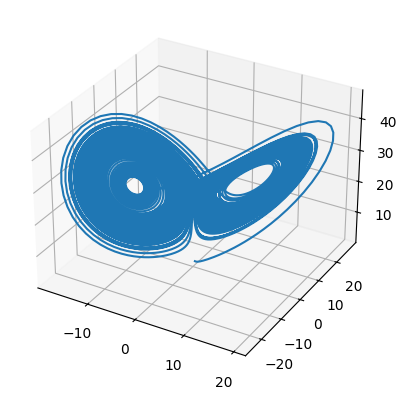

In [5]:
# set the initial conditions
initial_conditions = [0, 1, 1.05]

# plot the lorenz attractor
t = np.arange(0, 100, 0.01)
xyz = sp.integrate.odeint(lorenz_attractor, initial_conditions, t)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xyz[:,0], xyz[:,1], xyz[:,2])
plt.show()


# Learning Coefficients of the Lorenz Attractor
Suppose that we don't know $\sigma, \beta, \rho$, and we want to learn these coefficients from the data. We can use the same approach as above, but now we will use the data from the Lorenz Attractor to learn the coefficients.

## Learned Coefficients using Lasso

In [6]:
# generate the data
t = np.arange(0, 100, 0.01)
xyz = sp.integrate.odeint(lorenz_attractor, initial_conditions, t)

# compute derivatives
dx = sigma*(xyz[:,1]-xyz[:,0])
dy = xyz[:,0]*(rho-xyz[:,2]) - xyz[:,1]
dz = xyz[:,0]*xyz[:,1] - beta*xyz[:,2]

Y = np.array([dx, dy, dz]).T

# solve using Least Squares Regression

# first create library of functions
ones = np.ones(len(t))
x = xyz[:,0]
y = xyz[:,1]
z = xyz[:,2]
x2 = x**2
y2 = y**2
z2 = z**2
xy = x*y
xz = x*z
yz = y*z

# create the library
A = np.array([ones, x, y, z, x2, y2, z2, xy, xz, yz]).T

# solve for the coefficients
clf = linear_model.Lasso(alpha=0.1)
clf.fit(A, Y)
coeff = clf.coef_

print(coeff)

[[ 0.00000000e+00 -9.32932836e+00  9.57834695e+00  0.00000000e+00
  -0.00000000e+00 -2.97748377e-04  1.31185558e-05  3.77986997e-04
  -1.87114613e-02  1.16615808e-02]
 [ 0.00000000e+00  2.73175980e+01 -5.70939517e-01 -0.00000000e+00
   1.40022748e-05  3.13924573e-04 -1.38321620e-05 -4.08778937e-04
  -9.80949854e-01 -1.18771990e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.40396241e+00
   3.51166828e-02  6.44179780e-03 -7.64805903e-03  9.68564339e-01
  -7.00352363e-06  5.14294092e-05]]


/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.369e+04, tolerance: 1.782e+03
  model = cd_fast.enet_coordinate_descent(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.168e+04, tolerance: 4.179e+03
  model = cd_fast.enet_coordinate_descent(


## Plotting Learned Attractor vs Original Attractor

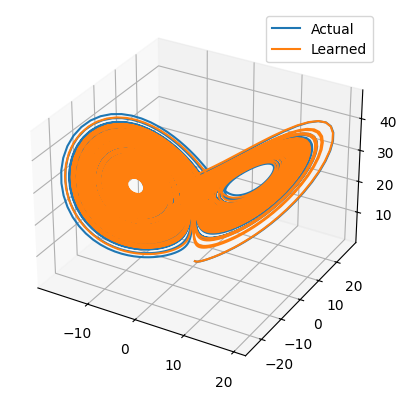

In [7]:
# plot Lorenz Attract using learned coefficients
def lorenz_attractor_learned(xyz, t):
    x, y, z = xyz
    dx_dt = coeff[0,0] + coeff[0,1]*x + coeff[0,2]*y + coeff[0,3]*z + coeff[0,4]*x**2 + coeff[0,5]*y**2 + coeff[0,6]*z**2 + coeff[0,7]*x*y + coeff[0,8]*x*z + coeff[0,9]*y*z
    dy_dt = coeff[1,0] + coeff[1,1]*x + coeff[1,2]*y + coeff[1,3]*z + coeff[1,4]*x**2 + coeff[1,5]*y**2 + coeff[1,6]*z**2 + coeff[1,7]*x*y + coeff[1,8]*x*z + coeff[1,9]*y*z
    dz_dt = coeff[2,0] + coeff[2,1]*x + coeff[2,2]*y + coeff[2,3]*z + coeff[2,4]*x**2 + coeff[2,5]*y**2 + coeff[2,6]*z**2 + coeff[2,7]*x*y + coeff[2,8]*x*z + coeff[2,9]*y*z
    return [dx_dt, dy_dt, dz_dt]

# set the initial conditions
initial_conditions = [0, 1, 1.05]

# plot the learned lorenz attractor and actual Lorenz Attractor
t = np.arange(0, 100, 0.01)
xyz = sp.integrate.odeint(lorenz_attractor, initial_conditions, t)
xyz_learned = sp.integrate.odeint(lorenz_attractor_learned, initial_conditions, t)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xyz[:,0], xyz[:,1], xyz[:,2], label='Actual')
ax.plot(xyz_learned[:,0], xyz_learned[:,1], xyz_learned[:,2], label='Learned')
plt.legend()
plt.show()


### Animation

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation



t = np.arange(0, 20, 0.01)
xyz = sp.integrate.odeint(lorenz_attractor, initial_conditions, t)
xyz_learned = sp.integrate.odeint(lorenz_attractor_learned, initial_conditions, t)

def init():
    return lines

def update(num, lines):
    for line, data in zip(lines, [xyz, xyz_learned]):
        line.set_data(data[:num, 0], data[:num, 1])
        line.set_3d_properties(data[:num, 2])
    return lines


# Attaching 3D axis to the figure
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# Create lines initially without data
lines = [ax.plot([], [], [])[0] for _ in range(2)]

# Setting the axes properties
ax.set(xlim3d=(-20, 40), xlabel='X')
ax.set(ylim3d=(-20, 40), ylabel='Y')
ax.set(zlim3d=(-20, 40), zlabel='Z')

# Creating the Animation object
ani = animation.FuncAnimation(
    fig, update, len(t), fargs=[lines], init_func=init, blit=True, interval=25, repeat=False)

ani.save('lorenz_attractor.gif', writer='imagemagick', fps=60)

<IPython.core.display.Javascript object>

MovieWriter imagemagick unavailable; using Pillow instead.


## Error Analysis

### L2 Norm Error

In [9]:
# Find Error between learned and actual Lorenz Attractor coefficients
error = np.linalg.norm(xyz-xyz_learned)
print(error)

579.1409345280397


### Procrustes Distance

In [10]:
mtx1, mtx2, disparity = procrustes(xyz, xyz_learned)
round(disparity)

1

### Wasserstein Distance

In [11]:
print(wasserstein_distance(xyz.flatten(), xyz_learned.flatten()))

0.7738470603214754


### Cloud Error

In [12]:
def sumsq_inf_distance(dataset, reference):
    '''
    Sum of square distances from the dataset to a reference dataset
    in a minimal way:
    
    sum_i min_j || x[i] - y[j] ||_2
    
    i runs over rows of dataset;
    j runs over rows of reference.
    
    Datasets do not need to have the same number of data points.
    
    Works through scipy.spatial.distance_matrix and np.min.
    
    Inputs:
        dataset:   2D array; shape (m,d)
        reference: 2D array; shape (n,d)
    Outputs:
        s: float; the metric above.
    '''
    from scipy import spatial
    
    D = spatial.distance_matrix(dataset, reference)
    min_distances = np.min(D, axis=1)
    s = sum(min_distances)
    
    return s
cloud_error = sumsq_inf_distance(xyz_learned,xyz)
print(cloud_error)

584.234408483679


# Experiments
## Varying Time Frame

In [48]:
# Experiment of error over different intervals over the main interval of 0 <= t <= 100
error = pd.DataFrame(columns=['Step Size', 'L2', 'Cloud', 'Wasserstein', 'Procrustes'], index=None)
step_sizes = [1,5,10,20,50]

approx_data = []
exact_data = []

for step_size in step_sizes:
    L2 = 0
    Cloud = 0
    Wasserstein = 0
    Procrustes = 0

    approx_trial = np.empty(shape=(1,3))
    exact_trial = np.empty(shape=(1,3))


    for i in range(0,int(100/(step_size))):

        t = np.arange(i*step_size, (i+1)*step_size, 0.01)
        xyz = sp.integrate.odeint(lorenz_attractor, initial_conditions, t)
        xyz_learned = sp.integrate.odeint(lorenz_attractor_learned, initial_conditions, t)
        L2 += np.linalg.norm(xyz-xyz_learned)
        Cloud += sumsq_inf_distance(xyz_learned,xyz)
        Wasserstein += wasserstein_distance(xyz.flatten(), xyz_learned.flatten())
        mtx1, mtx2, disparity = procrustes(xyz, xyz_learned)
        Procrustes += disparity
        approx_trial = np.concatenate((approx_trial,xyz_learned),axis=0)
        exact_trial = np.concatenate((exact_trial,xyz),axis=0)

    approx_trial = np.delete(approx_trial, (0), axis=0)
    exact_trial_trial = np.delete(exact_trial, (0), axis=0)
    approx_data.append(approx_trial)
    exact_data.append(exact_trial)
    
    error = pd.concat([error, pd.DataFrame([[step_size, L2, Cloud, Wasserstein, Procrustes]], columns=['Step Size', 'L2', 'Cloud', 'Wasserstein', 'Procrustes'], index=None)])

error.to_csv('error_step_size.csv', index=False)

/tmp/ipykernel_1492/1389744551.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  error = pd.concat([error, pd.DataFrame([[step_size, L2, Cloud, Wasserstein, Procrustes]], columns=['Step Size', 'L2', 'Cloud', 'Wasserstein', 'Procrustes'], index=None)])


In [49]:
# plot approx and exact data
t = np.arange(0, 100, 0.01)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(exact_data[0][:,0], exact_data[0][:,1], exact_data[0][:,2], label='Exact')
ax.plot(approx_data[0][:,0], approx_data[0][:,1], approx_data[0][:,2], label='Approx')
plt.legend()
plt.savefig('lorenz_attractor_step_size_1.png')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(exact_data[1][:,0], exact_data[1][:,1], exact_data[1][:,2], label='Exact')
ax.plot(approx_data[1][:,0], approx_data[1][:,1], approx_data[1][:,2], label='Approx')
plt.legend()
plt.savefig('lorenz_attractor_step_size_5.png')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(exact_data[2][:,0], exact_data[2][:,1], exact_data[2][:,2], label='Exact')
ax.plot(approx_data[2][:,0], approx_data[2][:,1], approx_data[2][:,2], label='Approx')
plt.legend()
plt.savefig('lorenz_attractor_step_size_10.png')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(exact_data[3][:,0], exact_data[3][:,1], exact_data[3][:,2], label='Exact')
ax.plot(approx_data[3][:,0], approx_data[3][:,1], approx_data[3][:,2], label='Approx')
plt.legend()
plt.savefig('lorenz_attractor_step_size_20.png')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(exact_data[4][:,0], exact_data[4][:,1], exact_data[4][:,2], label='Exact')
ax.plot(approx_data[4][:,0], approx_data[4][:,1], approx_data[4][:,2], label='Approx')
plt.legend()
plt.savefig('lorenz_attractor_step_size_50.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
# plot error
error = pd.read_csv('error_step_size.csv')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(error['Step Size'], error['L2'], label='L2')
ax.plot(error['Step Size'], error['Cloud'], label='Cloud')
ax.plot(error['Step Size'], error['Wasserstein'], label='Wasserstein')
ax.plot(error['Step Size'], error['Procrustes'], label='Procrustes')
plt.title('Error vs Step Size')
plt.xlabel('Step Size')
plt.ylabel('Error')
plt.grid()
plt.legend()
plt.savefig('error_step_size.png')

<IPython.core.display.Javascript object>

#  Lorenz Attractor (reminder)
Next we will attempt to implement our approach above for the Lorenz Attractor descroibed as,

\begin{align*}
\frac{dx}{dt} &= \sigma(y-x) \\
\frac{dy}{dt} &= x(\rho - z) - y \\
\frac{dz}{dt} &= xy -\beta z
\end{align*}

here we will consider the case that $\sigma = 10, \beta=\frac{8}{3}, \rho=28$, with intial condition $x(0)=0, y(0)=1, z(0)=1.05$.

In [15]:
coeff_exact = np.zeros(coeff.shape)
# order of terms goes..
# 1, x, y, z, x^2, y^2, z^2, xy, xz, yz

# dx/dt
coeff_exact[0, 1] = -sigma
coeff_exact[0, 2] = +sigma
# dy/dt
coeff_exact[1, 1] = rho
coeff_exact[1, 2] = -1
coeff_exact[1, 8] = -1
# dz/dt
coeff_exact[2, 7] = 1
coeff_exact[2, 3] = -beta

In [16]:
fig,ax = plt.subplots(2,1, sharex=True, sharey=True, constrained_layout=True)

ax[0].matshow(coeff, vmin=-abs(coeff_exact).max(), vmax=abs(coeff_exact).max(), cmap=plt.cm.bwr)
ax[1].matshow(coeff_exact, vmin=-abs(coeff_exact).max(), vmax=abs(coeff_exact).max(), cmap=plt.cm.bwr)

# Conditionally label cell with their values
# modified from https://stackoverflow.com/a/20998634
for (i, j), z in np.ndenumerate(coeff):
    if abs(z) > 1e-1:
        ax[0].text(j, i, '{:0.1f}'.format(z), ha='center', va='center', color='k')
for (i, j), z in np.ndenumerate(coeff_exact):
    if abs(z) > 1e-1:
        ax[1].text(j, i, '{:0.1f}'.format(z), ha='center', va='center', color='k')


ax[0].set(title='Estimated coefficient matrix', yticks=[0,1,2], yticklabels=['dx/dt', 'dy/dt', 'dz/dt'])
ax[1].set(title='Exact coefficient matrix', yticks=[0,1,2], yticklabels=['dx/dt', 'dy/dt', 'dz/dt'])


<IPython.core.display.Javascript object>

[Text(0.5, 1.0, 'Exact coefficient matrix'),
 [Text(0, 0, 'dx/dt'), Text(0, 1, 'dy/dt'), Text(0, 2, 'dz/dt')]]

In [17]:
idx = np.where(abs(coeff - coeff_exact) > 1e-1)
print(coeff[idx])
print(coeff_exact[idx])

[-9.32932836  9.57834695 27.31759803 -0.57093952 -2.40396241]
[-10.          10.          28.          -1.          -2.66666667]
